In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim

In [2]:
torch.manual_seed(42)
BATCH_SIZE= 32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset= MNIST(root= './data', train= True, download= True, transform= transform)
test_dataset= MNIST(root= './data', train= False, download= True, transform= transform)
train_loader= DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader= DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.88MB/s]


In [3]:
len(train_dataset), len(test_dataset)

(60000, 10000)

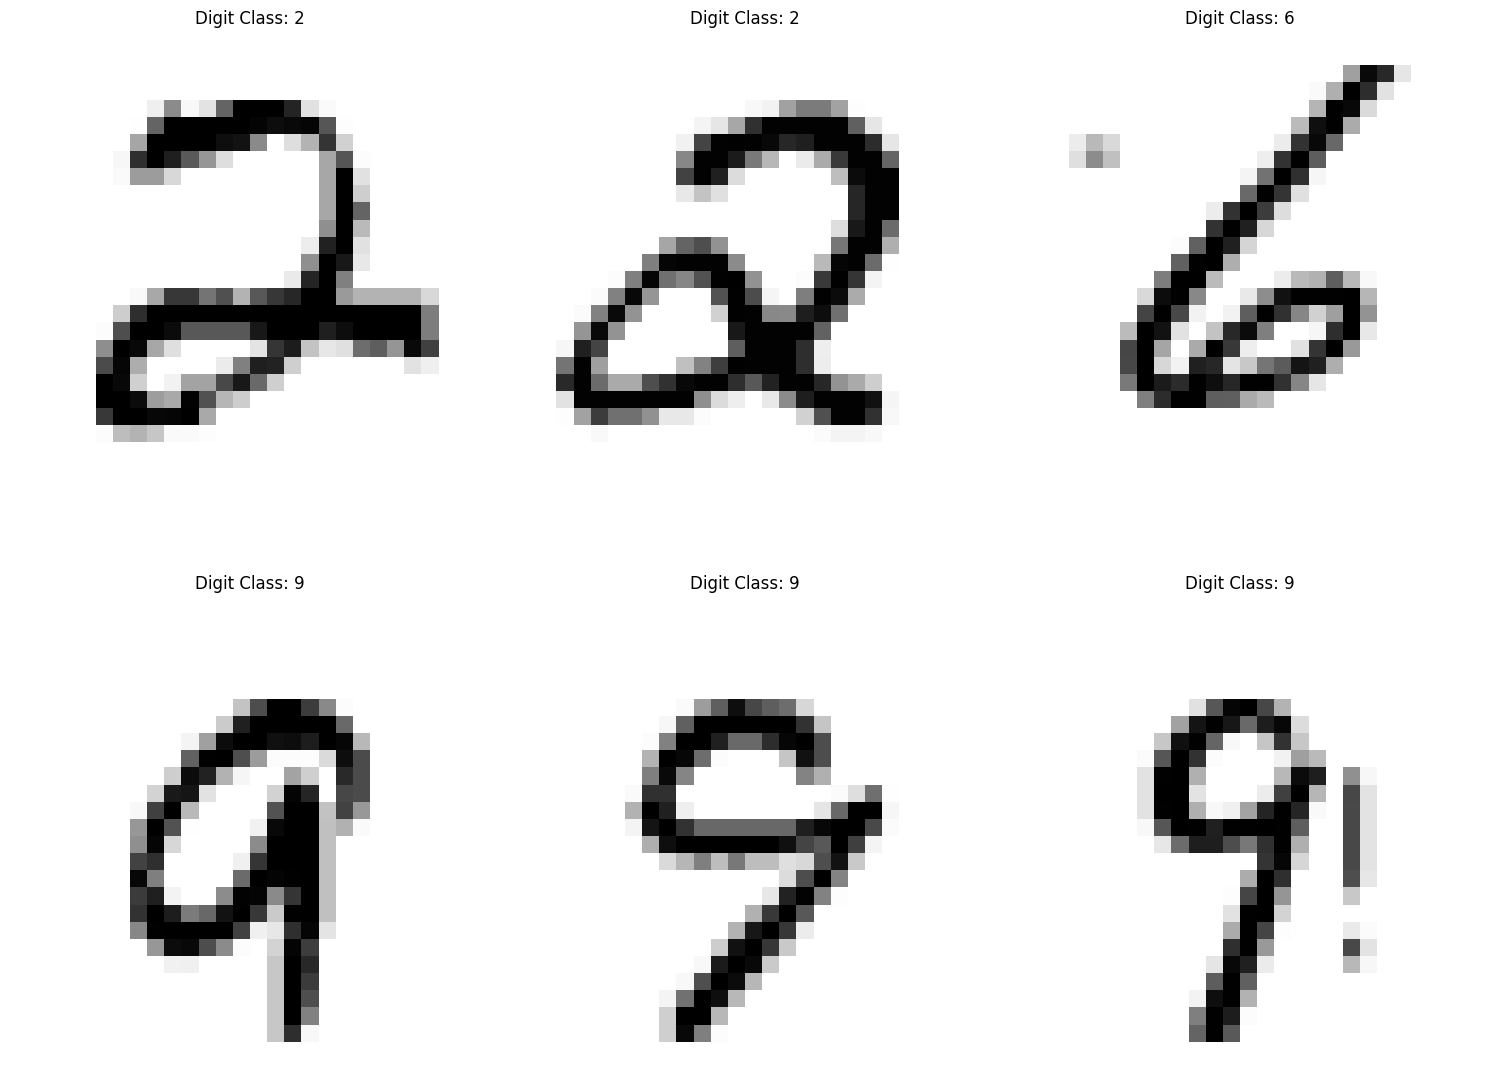

In [4]:
def display_images(images, labels, indices, n_rows= 2, n_cols= 3, figsize= (15,12)):
    fig, axes= plt.subplots(n_rows, n_cols, figsize= figsize)

    axes= axes.flatten()
    for i, idx in enumerate(indices):
        image= images[idx].numpy()
        label= labels[idx].item()

        axes[i].imshow(image.squeeze(), cmap= plt.cm.binary)
        axes[i].axis(False)
        axes[i].set_title(f"Digit Class: {label}")
    plt.tight_layout()
    plt.show()

images, labels= next(iter(train_loader))
indices= [1, 4, 5, 6, 7, 8]
display_images(images, labels, indices)

In [5]:
class TinyMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 1024) # Input Shape: 28x28= 784, Out Shape: 1024
        nn.init.kaiming_normal_(self.fc1.weight, mode= 'fan_in', nonlinearity= 'relu')
        self.relu1= nn.ReLU()

        self.fc2= nn.Linear(1024, 512) # Input Shape: 1024, Out Shape: 512
        nn.init.kaiming_normal_(self.fc2.weight, mode= 'fan_in', nonlinearity= 'relu')
        self.relu2= nn.ReLU()

        self.fc3= nn.Linear(512, 256) # Input Shape: 512, Out Shape: 256
        nn.init.kaiming_normal_(self.fc3.weight, mode= 'fan_in', nonlinearity= 'relu')
        self.relu3= nn.ReLU()

        self.output= nn.Linear(256, 10) # In Shape: 256, Outshape: num classes = 10

        if self.fc1.bias is not None:
            nn.init.constant_(self.fc1.bias, 0)
        if self.fc2.bias is not None:
            nn.init.constant_(self.fc2.bias, 0)
        if self.fc3.bias is not None:
            nn.init.constant_(self.fc3.bias, 0)

        self.activation_std_history= [] # List of Dicts: [{'fc1': std, ....}, ...]
        self.gradient_std_history= [] # Same for gradients

    def forward(self, x):

        x= x.view(x.size(0), -1)

        features= self.relu1(self.fc1(x))
        features= self.relu2(self.fc2(features))
        features= self.relu3(self.fc3(features))

        out_logits= self.output(features)

        return out_logits

    def register_std_hooks(self):
        # Temporary trackers for current pass
        self.activation_stds = {}
        self.gradient_stds = {}
        # Forward hook function (closure)
        def forward_hook(module, input, output):
              # Compute std of output activations (flatten to 1D for global std)
              layer_name= module.__class__.__name__
              if output.numel() > 1:  # Avoid std on empty/scalar tensors
                  std = torch.std(output.detach().view(-1)).item()
                  self.activation_stds[layer_name] = std
              else:
                  self.activation_stds[layer_name] = 0.0  # Fallback


        # Backward hook function (closure)
        def backward_hook(module, grad_input, grad_output):
              layer_name= module.__class__.__name__
              if grad_output[0] is not None and grad_output[0].numel() > 1:
                  std = torch.std(grad_output[0].detach().view(-1)).item()
                  self.gradient_stds[layer_name] = std
              else:
                  self.gradient_stds[layer_name] = 0.0  # Fallback



        # Register hooks on key layers
        self.fc1.register_forward_hook(forward_hook)
        self.fc1.register_full_backward_hook(backward_hook)

        self.fc2.register_forward_hook(forward_hook)
        self.fc2.register_full_backward_hook(backward_hook)

        self.fc3.register_forward_hook(forward_hook)
        self.fc3.register_full_backward_hook(backward_hook)


        self.relu1.register_forward_hook(forward_hook)
        self.relu1.register_full_backward_hook(backward_hook)

        self.relu2.register_forward_hook(forward_hook)
        self.relu2.register_full_backward_hook(backward_hook)

        self.relu3.register_forward_hook(forward_hook)
        self.relu3.register_full_backward_hook(backward_hook)

        self.output.register_forward_hook(forward_hook)
        self.output.register_full_backward_hook(backward_hook)

    # Append current pass stds to history and clear temp trackers (unchanged, it's good)
    def log_std_to_history(self):
        self.activation_std_history.append(self.activation_stds.copy())
        self.gradient_std_history.append(self.gradient_stds.copy())
        self.activation_stds = {}
        self.gradient_stds = {}

In [6]:
class DropoutMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 1024) # Input Shape: 28x28= 784, Out Shape: 512
        nn.init.kaiming_normal_(self.fc1.weight, mode= 'fan_in', nonlinearity= 'relu')
        self.relu1= nn.ReLU()
        self.dropout1= nn.Dropout(0.3)

        self.fc2= nn.Linear(1024, 512) # Input Shape: 512, Out Shape: 256
        nn.init.kaiming_normal_(self.fc2.weight, mode= 'fan_in', nonlinearity= 'relu')
        self.relu2= nn.ReLU()
        self.dropout2= nn.Dropout(0.3)

        self.fc3= nn.Linear(512, 256)
        nn.init.kaiming_normal_(self.fc3.weight, mode= 'fan_in', nonlinearity= 'relu')
        self.relu3= nn.ReLU()
        self.dropout3= nn.Dropout(0.3)

        self.output= nn.Linear(256, 10) # In Shape: 256, Outshape: num classes = 10

        if self.fc1.bias is not None:
            nn.init.constant_(self.fc1.bias, 0)
        if self.fc2.bias is not None:
            nn.init.constant_(self.fc2.bias, 0)
        if self.fc3.bias is not None:
            nn.init.constant_(self.fc3.bias, 0)

        self.activation_std_history= [] # List of Dicts: [{'fc1': std, ....}, ...]
        self.gradient_std_history= [] # Same for gradients

    def forward(self, x):

        x= x.view(x.size(0), -1)

        features= self.dropout1(self.relu1(self.fc1(x)))
        features= self.dropout2(self.relu2(self.fc2(features)))
        features= self.dropout3(self.relu3(self.fc3(features)))

        out_logits= self.output(features)

        return out_logits

    def register_std_hooks(self):
        # Temporary trackers for current pass
        self.activation_stds = {}
        self.gradient_stds = {}
        # Forward hook function (closure)
        def forward_hook(module, input, output):
              # Compute std of output activations (flatten to 1D for global std)
              layer_name= module.__class__.__name__
              if output.numel() > 1:  # Avoid std on empty/scalar tensors
                  std = torch.std(output.detach().view(-1)).item()
                  self.activation_stds[layer_name] = std
              else:
                  self.activation_stds[layer_name] = 0.0  # Fallback


        # Backward hook function (closure)
        def backward_hook(module, grad_input, grad_output):
              layer_name= module.__class__.__name__
              if grad_output[0] is not None and grad_output[0].numel() > 1:
                  std = torch.std(grad_output[0].detach().view(-1)).item()
                  self.gradient_stds[layer_name] = std
              else:
                  self.gradient_stds[layer_name] = 0.0  # Fallback



        # Register hooks on key layers
        self.fc1.register_forward_hook(forward_hook)
        self.fc1.register_full_backward_hook(backward_hook)

        self.fc2.register_forward_hook(forward_hook)
        self.fc2.register_full_backward_hook(backward_hook)

        self.fc3.register_forward_hook(forward_hook)
        self.fc3.register_full_backward_hook(backward_hook)


        self.relu1.register_forward_hook(forward_hook)
        self.relu1.register_full_backward_hook(backward_hook)

        self.relu2.register_forward_hook(forward_hook)
        self.relu2.register_full_backward_hook(backward_hook)

        self.relu3.register_forward_hook(forward_hook)
        self.relu3.register_full_backward_hook(backward_hook)

        self.output.register_forward_hook(forward_hook)
        self.output.register_full_backward_hook(backward_hook)

    # Append current pass stds to history and clear temp trackers (unchanged, it's good)
    def log_std_to_history(self):
        self.activation_std_history.append(self.activation_stds.copy())
        self.gradient_std_history.append(self.gradient_stds.copy())
        self.activation_stds = {}
        self.gradient_stds = {}

In [7]:
def train_eval_model(model,
                     train_loader,
                     test_loader,
                     optimizer,
                     num_epochs,
                     device,
                     loss_fn,
                     target_accuracy= None,
                     scheduler= None
                     ):
    train_loss_history= []
    val_loss_history= []
    train_acc_history= []
    val_acc_history= []
    activation_std_history= []
    gradient_std_history= []
    patience= 3
    best_val_accuracy= 0.0
    epochs_with_no_improvement= 0
    min_delta= 0.1
    model.register_std_hooks()

    for epoch in range(num_epochs):
        model.train()
        running_train_loss= 0.0
        train_correct= 0
        train_total= 0

        for images, labels in train_loader:
            images, labels= images.to(device), labels.to(device)
            preds= model(images)
            loss= loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss+= loss.item()

            # Calculate Training Accuracy
            _, predicted= torch.max(preds.data, 1)
            train_total+= labels.size(0)
            train_correct+= (predicted == labels).sum().item()

        model.log_std_to_history()
        activation_std_history.append(model.activation_std_history[-1])
        gradient_std_history.append(model.gradient_std_history[-1])

        model.eval()
        running_val_loss= 0.0
        val_correct= 0.0
        val_total= 0.0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels= images.to(device), labels.to(device)
                preds= model(images)
                loss= loss_fn(preds, labels)

                running_val_loss+= loss.item()

                # Calculate Val Accuracy
                _, predicted= torch.max(preds.data, 1)
                val_total+= labels.size(0)
                val_correct+= (predicted == labels).sum().item()

        running_val_loss/= len(test_loader)


        running_train_loss/= len(train_loader)

        train_acc= (train_correct / train_total) * 100
        val_acc= (val_correct / val_total) * 100

        if val_acc >= best_val_accuracy + min_delta:
            best_val_accuracy= val_acc
            epochs_with_no_improvement= 0
        else:
            epochs_with_no_improvement+= 1

        # Log to history and print
        train_loss_history.append(running_train_loss)
        val_loss_history.append(running_val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} ")
        print("-" * 10)
        print(f"Train Loss: {running_train_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {running_val_loss:.4f}")
        print(f"Val Accuracy: {val_acc:.2f}%")
        print("Activation STDs:", model.activation_std_history[-1])
        print("Gradient STDs:", model.gradient_std_history[-1])
        print("-" * 50)

        if epochs_with_no_improvement >= patience:
            print(f"Early Stopping Triggered at epoch {epoch + 1}. No accuracy improvement after {patience} epochs")
            break

        if scheduler:
            scheduler.step(metrics= val_loss_history[-1])

    epochs= [epoch for epoch in range(1, len(train_loss_history) + 1)]
    return {
        "epochs": epochs,
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history,
        "train_acc_history": train_acc_history,
        "val_acc_history": val_acc_history,
        "activation_std_history": activation_std_history,
        "gradient_std_history": gradient_std_history
    }


In [8]:
torch.manual_seed(42)
LEARNING_RATE= 0.01
NUM_EPOCHS= 30

lambda_sgd= 1e-6
lambda_adam= 1e-6
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn= nn.CrossEntropyLoss()
label_smoothing_loss_fn= nn.CrossEntropyLoss(label_smoothing= 0.1)

# Control SGD Model
control_model= TinyMLP()
control_optimizer= optim.SGD(control_model.parameters(), LEARNING_RATE, momentum= 0.9)
control_scheduler= optim.lr_scheduler.ReduceLROnPlateau(control_optimizer, mode= 'min', factor= 1e-2, patience= 2)

# Dropout Model
dropout_model= DropoutMLP()
dropout_optimizer= optim.SGD(dropout_model.parameters(), LEARNING_RATE, momentum= 0.9)
dropout_scheduler= optim.lr_scheduler.ReduceLROnPlateau(dropout_optimizer, mode= 'min', factor= 1e-2, patience= 2)

# Label Smoothin Model
label_smoothing_model= TinyMLP()
label_smoothing_optimizer= optim.SGD(label_smoothing_model.parameters(), LEARNING_RATE, momentum= 0.9)
label_smoothing_scheduler= optim.lr_scheduler.ReduceLROnPlateau(label_smoothing_optimizer, mode= 'min', factor= 1e-2, patience= 2)

# Label Smoothing + Dropout Model
ls_dropout_model= DropoutMLP()
ls_dropout_optimizer= optim.SGD(ls_dropout_model.parameters(), LEARNING_RATE, momentum= 0.9)
ls_dropout_scheduler= optim.lr_scheduler.ReduceLROnPlateau(ls_dropout_optimizer, mode= 'min', factor= 1e-2, patience= 2)



print(f"Control MLP Training Start...")
print(f"-"*80)
control_model.to(device)
control_model_metrics= train_eval_model(model= control_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= control_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= control_scheduler)
print(f"-"*80)
print(f"Dropout MLP Training Start...")
print(f"-"*80)
dropout_model.to(device)
dropout_model_metrics= train_eval_model(model= dropout_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= dropout_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= dropout_scheduler)
print(f"-"*80)
print(f"Label Smoothing MLP Training Start...")
print(f"-"*80)
label_smoothing_model.to(device)
label_smoothing_model_metrics= train_eval_model(model= label_smoothing_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= label_smoothing_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= label_smoothing_loss_fn,
                                scheduler= label_smoothing_scheduler)
print(f"-"*80)
print(f"Label Smoothing and Dropout MLP Training Start...")
print(f"-"*80)
ls_dropout_model.to(device)
ls_dropout_model_metrics= train_eval_model(model= ls_dropout_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= ls_dropout_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= label_smoothing_loss_fn,
                                scheduler= ls_dropout_scheduler)
print(f"-"*80)

Control MLP Training Start...
--------------------------------------------------------------------------------


sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


Epoch 1/30 
----------
Train Loss: 0.1890
Train Accuracy: 94.11%
Val Loss: 0.0969
Val Accuracy: 97.05%
Activation STDs: {'Linear': 4.41574239730835, 'ReLU': 0.9336345195770264}
Gradient STDs: {'Linear': 0.00013333455717656761, 'ReLU': 0.00022436396102420986}
--------------------------------------------------
Epoch 2/30 
----------
Train Loss: 0.0688
Train Accuracy: 97.87%
Val Loss: 0.0818
Val Accuracy: 97.40%
Activation STDs: {'Linear': 5.935281276702881, 'ReLU': 1.0543696880340576}
Gradient STDs: {'Linear': 7.26713115000166e-05, 'ReLU': 0.0001112067184294574}
--------------------------------------------------
Epoch 3/30 
----------
Train Loss: 0.0376
Train Accuracy: 98.84%
Val Loss: 0.0722
Val Accuracy: 97.88%
Activation STDs: {'Linear': 6.430505275726318, 'ReLU': 1.0693410634994507}
Gradient STDs: {'Linear': 6.618570478167385e-05, 'ReLU': 0.00012158468598499894}
--------------------------------------------------
Epoch 4/30 
----------
Train Loss: 0.0226
Train Accuracy: 99.24%
Val Los

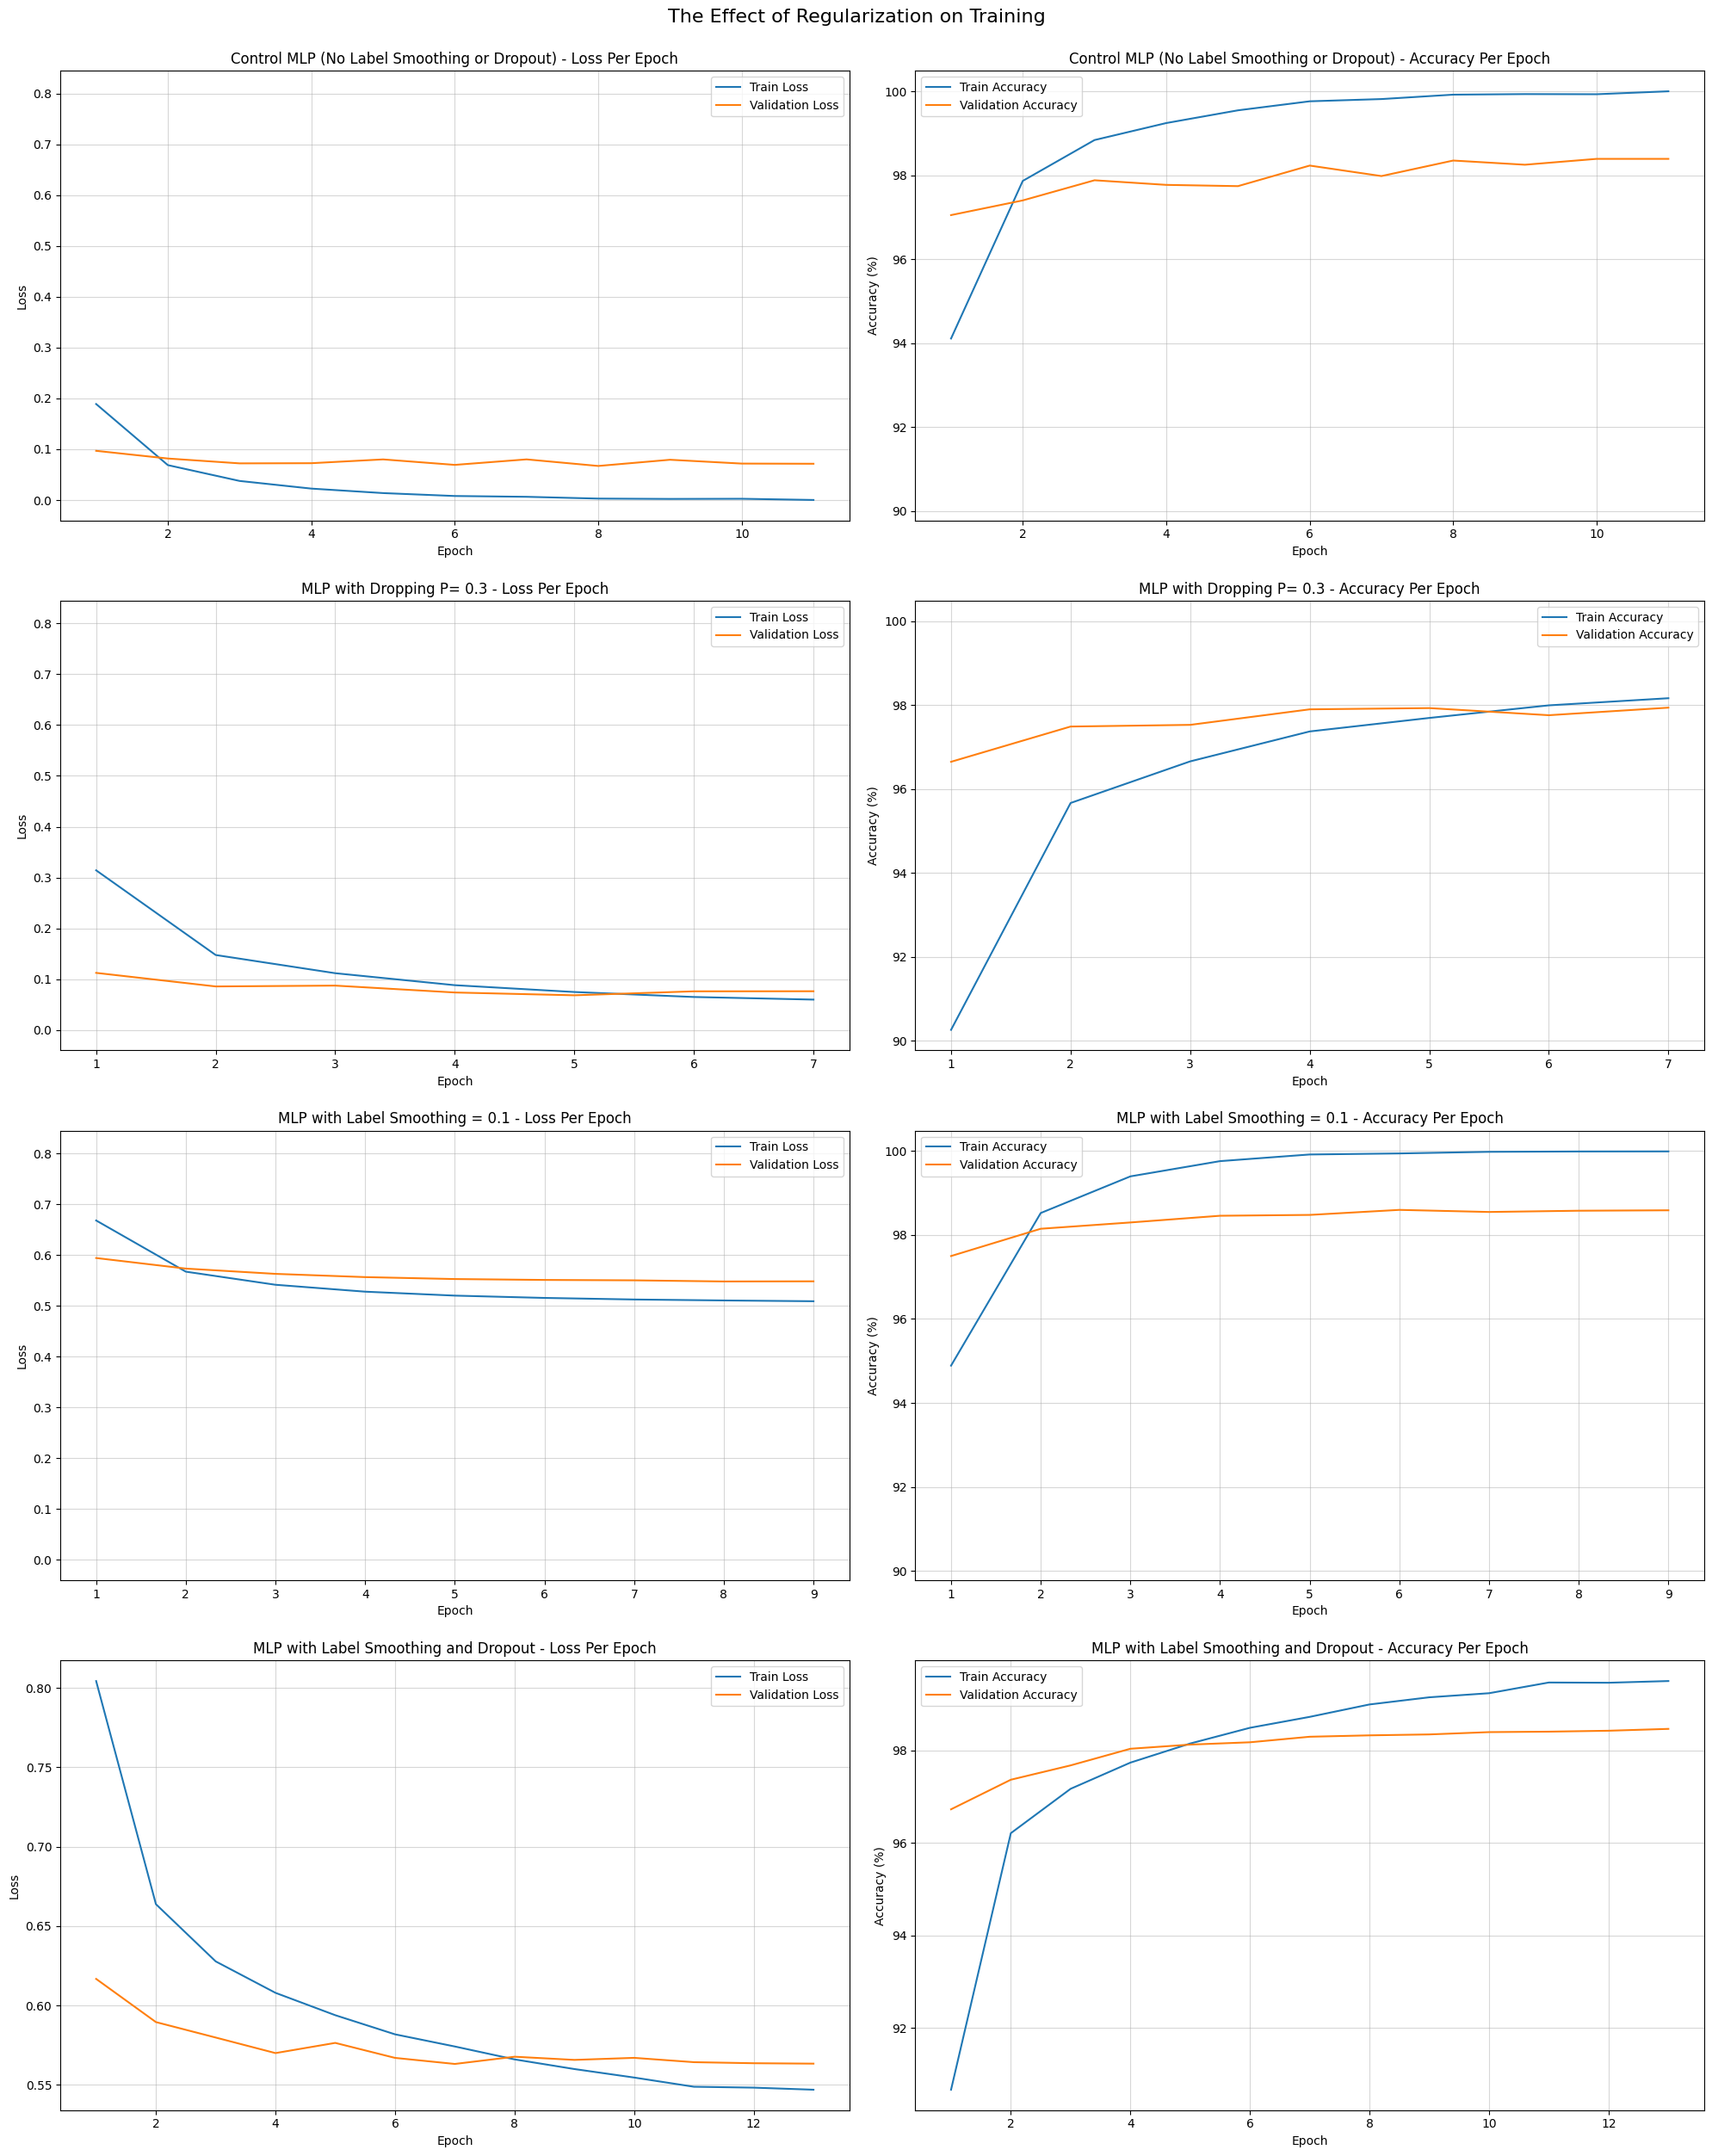

In [ ]:
# Create figure with 3 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(20, 25))

# Data to plot (model metrics)
models_data = [
    (control_model_metrics, "Control MLP (No Label Smoothing or Dropout)"),
    (dropout_model_metrics, "MLP with Dropping P= 0.3"),
    (label_smoothing_model_metrics, "MLP with Label Smoothing = 0.1"),
    (ls_dropout_model_metrics, "MLP with Label Smoothing and Dropout")
]

# Precompute global min and max for loss and accuracy
all_losses = []
all_accuracies = []
for metrics, _ in models_data:
    all_losses.extend(metrics["train_loss_history"])
    all_losses.extend(metrics["val_loss_history"])
    all_accuracies.extend(metrics["train_acc_history"])
    all_accuracies.extend(metrics["val_acc_history"])

# Add 5% padding to the ranges
loss_padding = (max(all_losses) - min(all_losses)) * 0.05
acc_padding = (max(all_accuracies) - min(all_accuracies)) * 0.05

# Set consistent y-axis limits for all plots
for i in range(4):
    # Left column (loss plots)
    axes[i, 0].set_ylim(min(all_losses) - loss_padding, max(all_losses) + loss_padding)

    # Right column (accuracy plots)
    axes[i, 1].set_ylim(min(all_accuracies) - acc_padding, max(all_accuracies) + acc_padding)

# Create plots for each model
for i, (metrics, title) in enumerate(models_data):
    # Left plot (loss)
    ax_left = axes[i, 0]
    ax_left.set_title(f"{title} - Loss Per Epoch")
    ax_left.grid(True, alpha=0.5)
    ax_left.set_xlabel("Epoch")
    ax_left.set_ylabel("Loss")
    p1 = ax_left.plot(metrics["epochs"], metrics["train_loss_history"], label='Train Loss')
    p2 = ax_left.plot(metrics["epochs"], metrics["val_loss_history"], label='Validation Loss')
    ax_left.legend()

    # Right plot (accuracy)
    ax_right = axes[i, 1]
    ax_right.set_title(f"{title} - Accuracy Per Epoch")
    ax_right.grid(True, alpha=0.5)
    ax_right.set_xlabel("Epoch")
    ax_right.set_ylabel("Accuracy (%)")
    p3 = ax_right.plot(metrics["epochs"], metrics["train_acc_history"], label='Train Accuracy')
    p4 = ax_right.plot(metrics["epochs"], metrics["val_acc_history"], label='Validation Accuracy')
    ax_right.legend()

# Add overall title and adjust layout
fig.suptitle(f"The Effect of Regularization on Training",
             fontsize=16, y=1.0)
fig.tight_layout(h_pad=2.0, w_pad=1.5)

plt.show()